In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('sythetic-data-augmentation-gans')
jovian.set_colab_id('1Qo3Ho4M9Dhy6sPV3qxzI0-9ZtQUMhj2L')

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
project_name = 'brain-tumour-synthetic-data-augmentation-gans'
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jayanthvikram
Your Kaggle Key: ··········


100%|██████████| 84.0M/84.0M [00:00<00:00, 149MB/s]


In [ ]:
import os
DATA_DIR = './brain-tumor-detection/Br35H-Mask-RCNN/'
print(os.listdir(DATA_DIR))

['TEST', 'annotations_all.json', 'VAL', 'TRAIN']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_dataset = ImageFolder(DATA_DIR, transform = T.Compose([
              T.Resize(image_size),
              T.CenterCrop(image_size),
              T.ToTensor(),
              T.Normalize(*stats)]))
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
  return img_tensors* stats[1][0] * stats[0][0]

In [ ]:
def show_images(images, nmax = 64):
  fig, ax = plt.subplots(figsize = (128,128))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


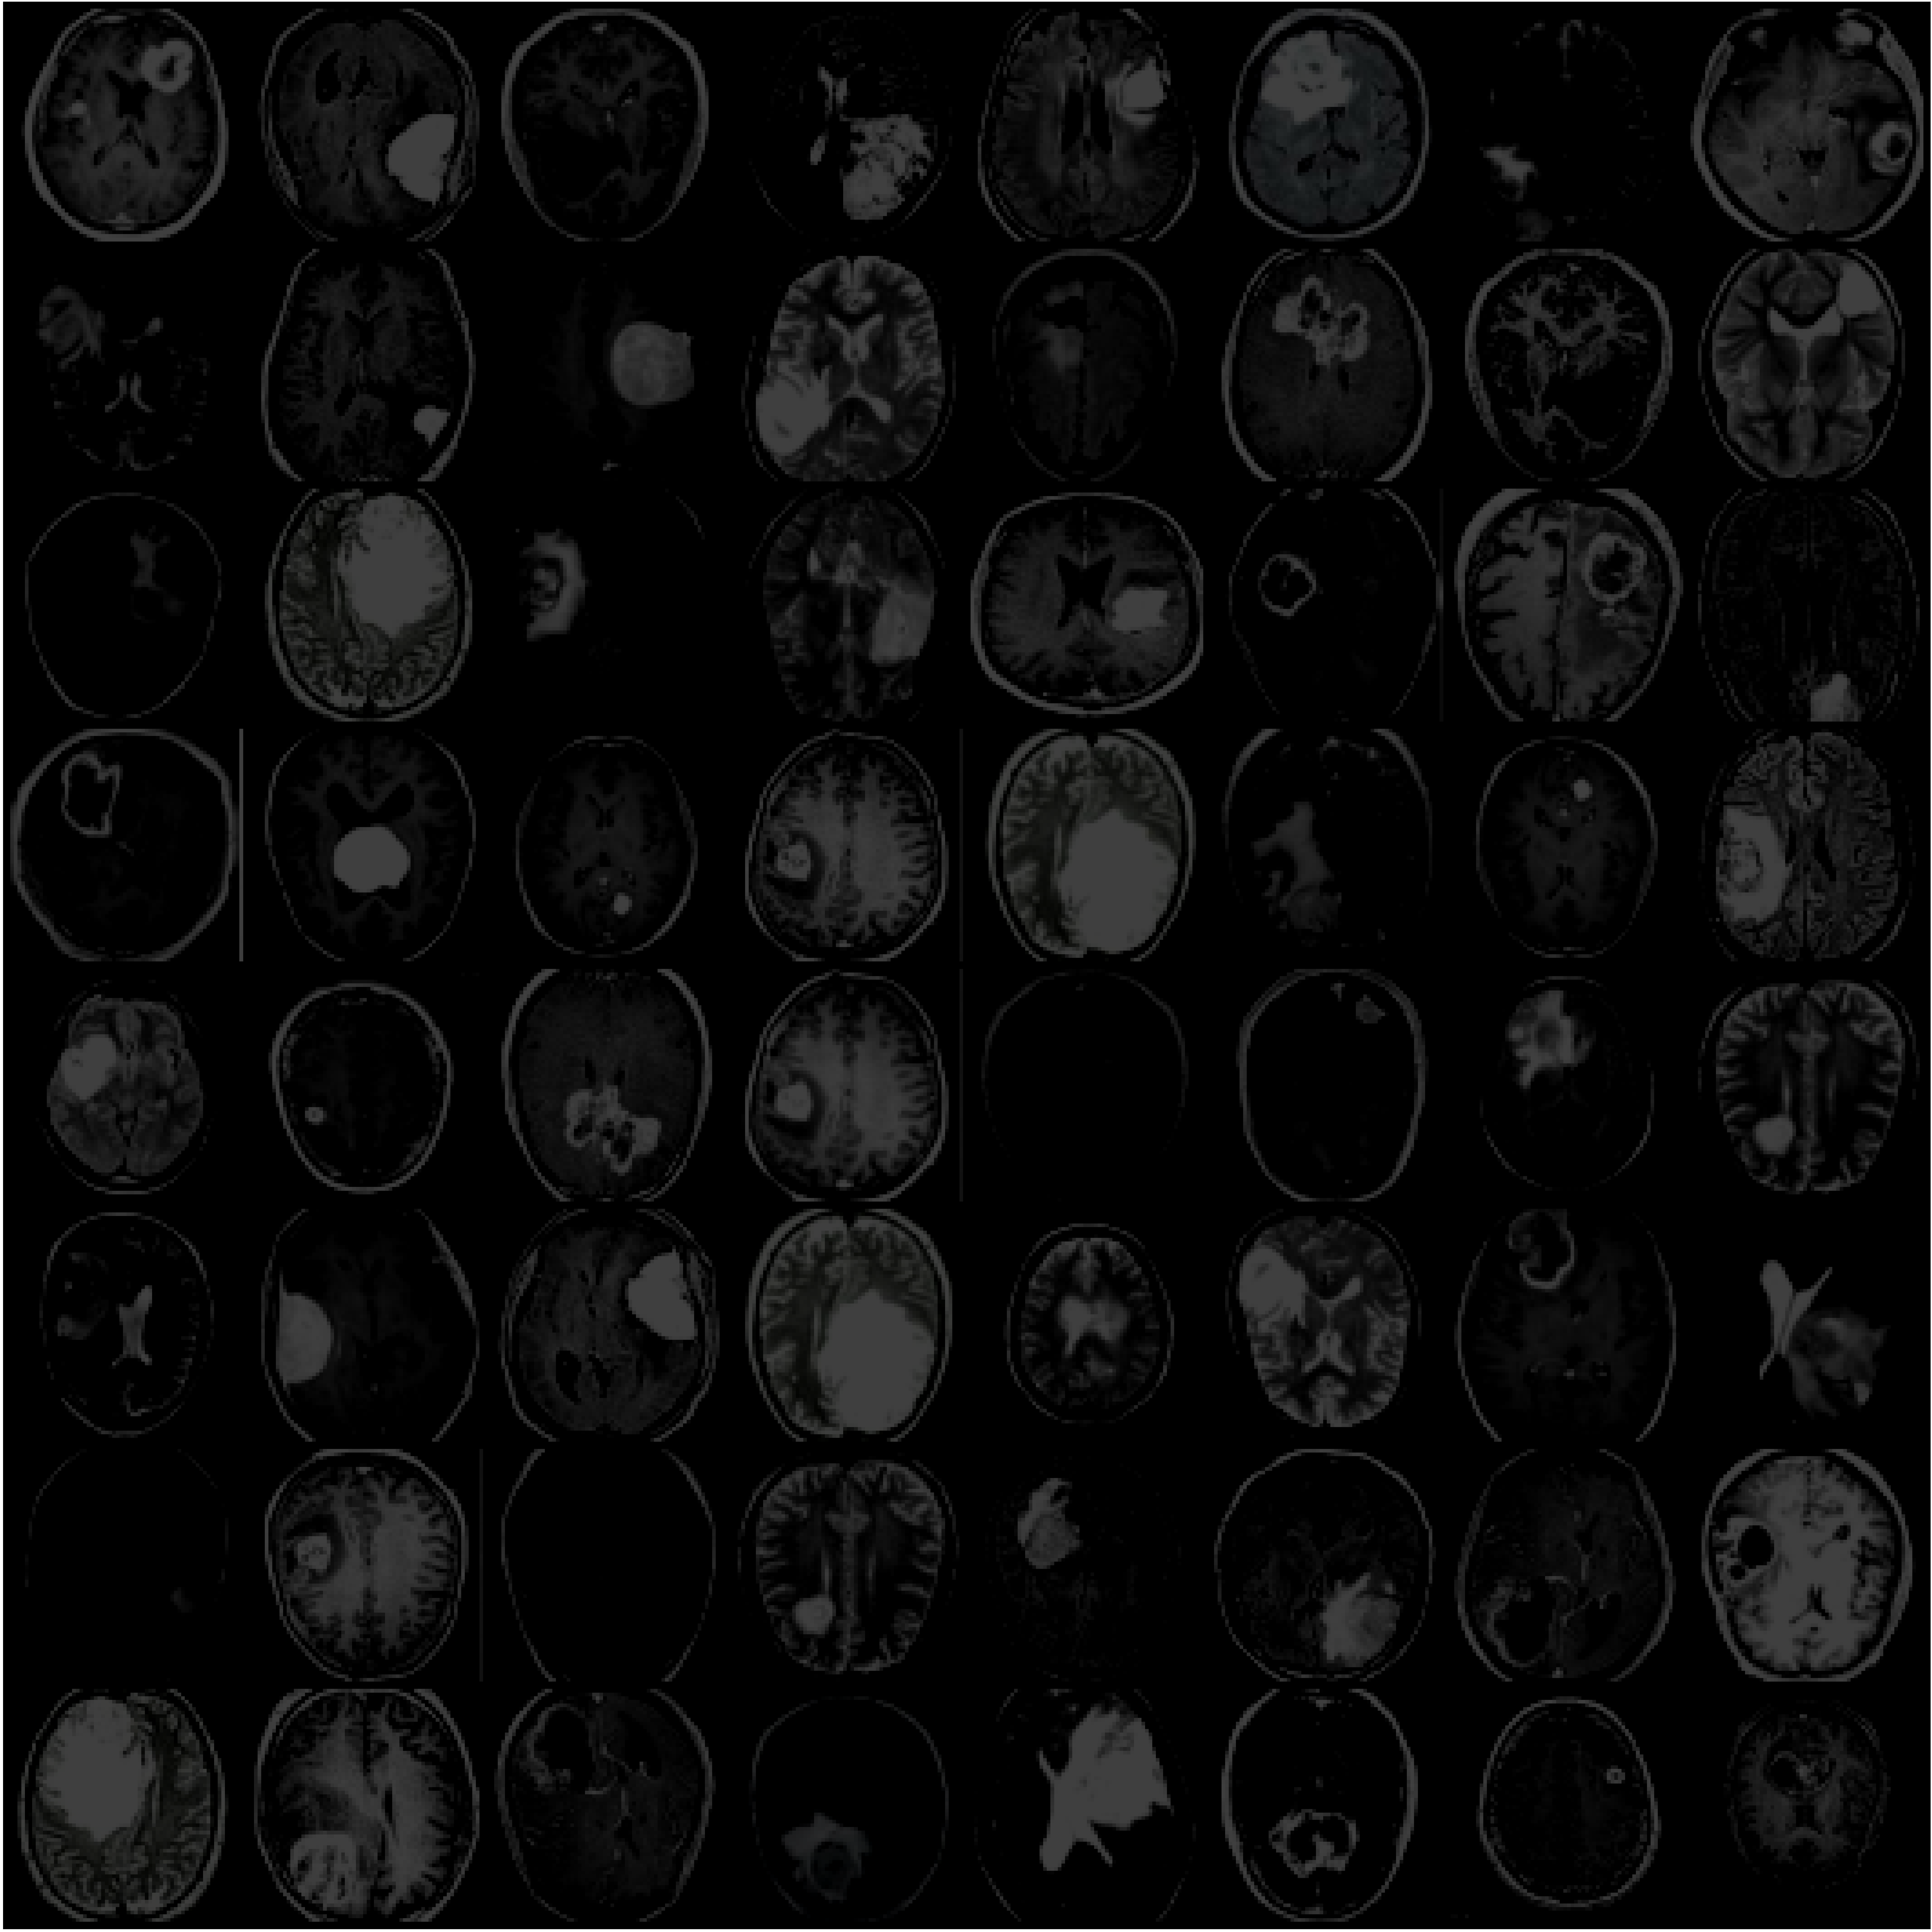

In [ ]:
show_batch(train_dl)

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name, environment = None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/jayanthvikram2000/brain-tumour-synthetic-data-augmentation-gans


'https://jovian.ai/jayanthvikram2000/brain-tumour-synthetic-data-augmentation-gans'

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])


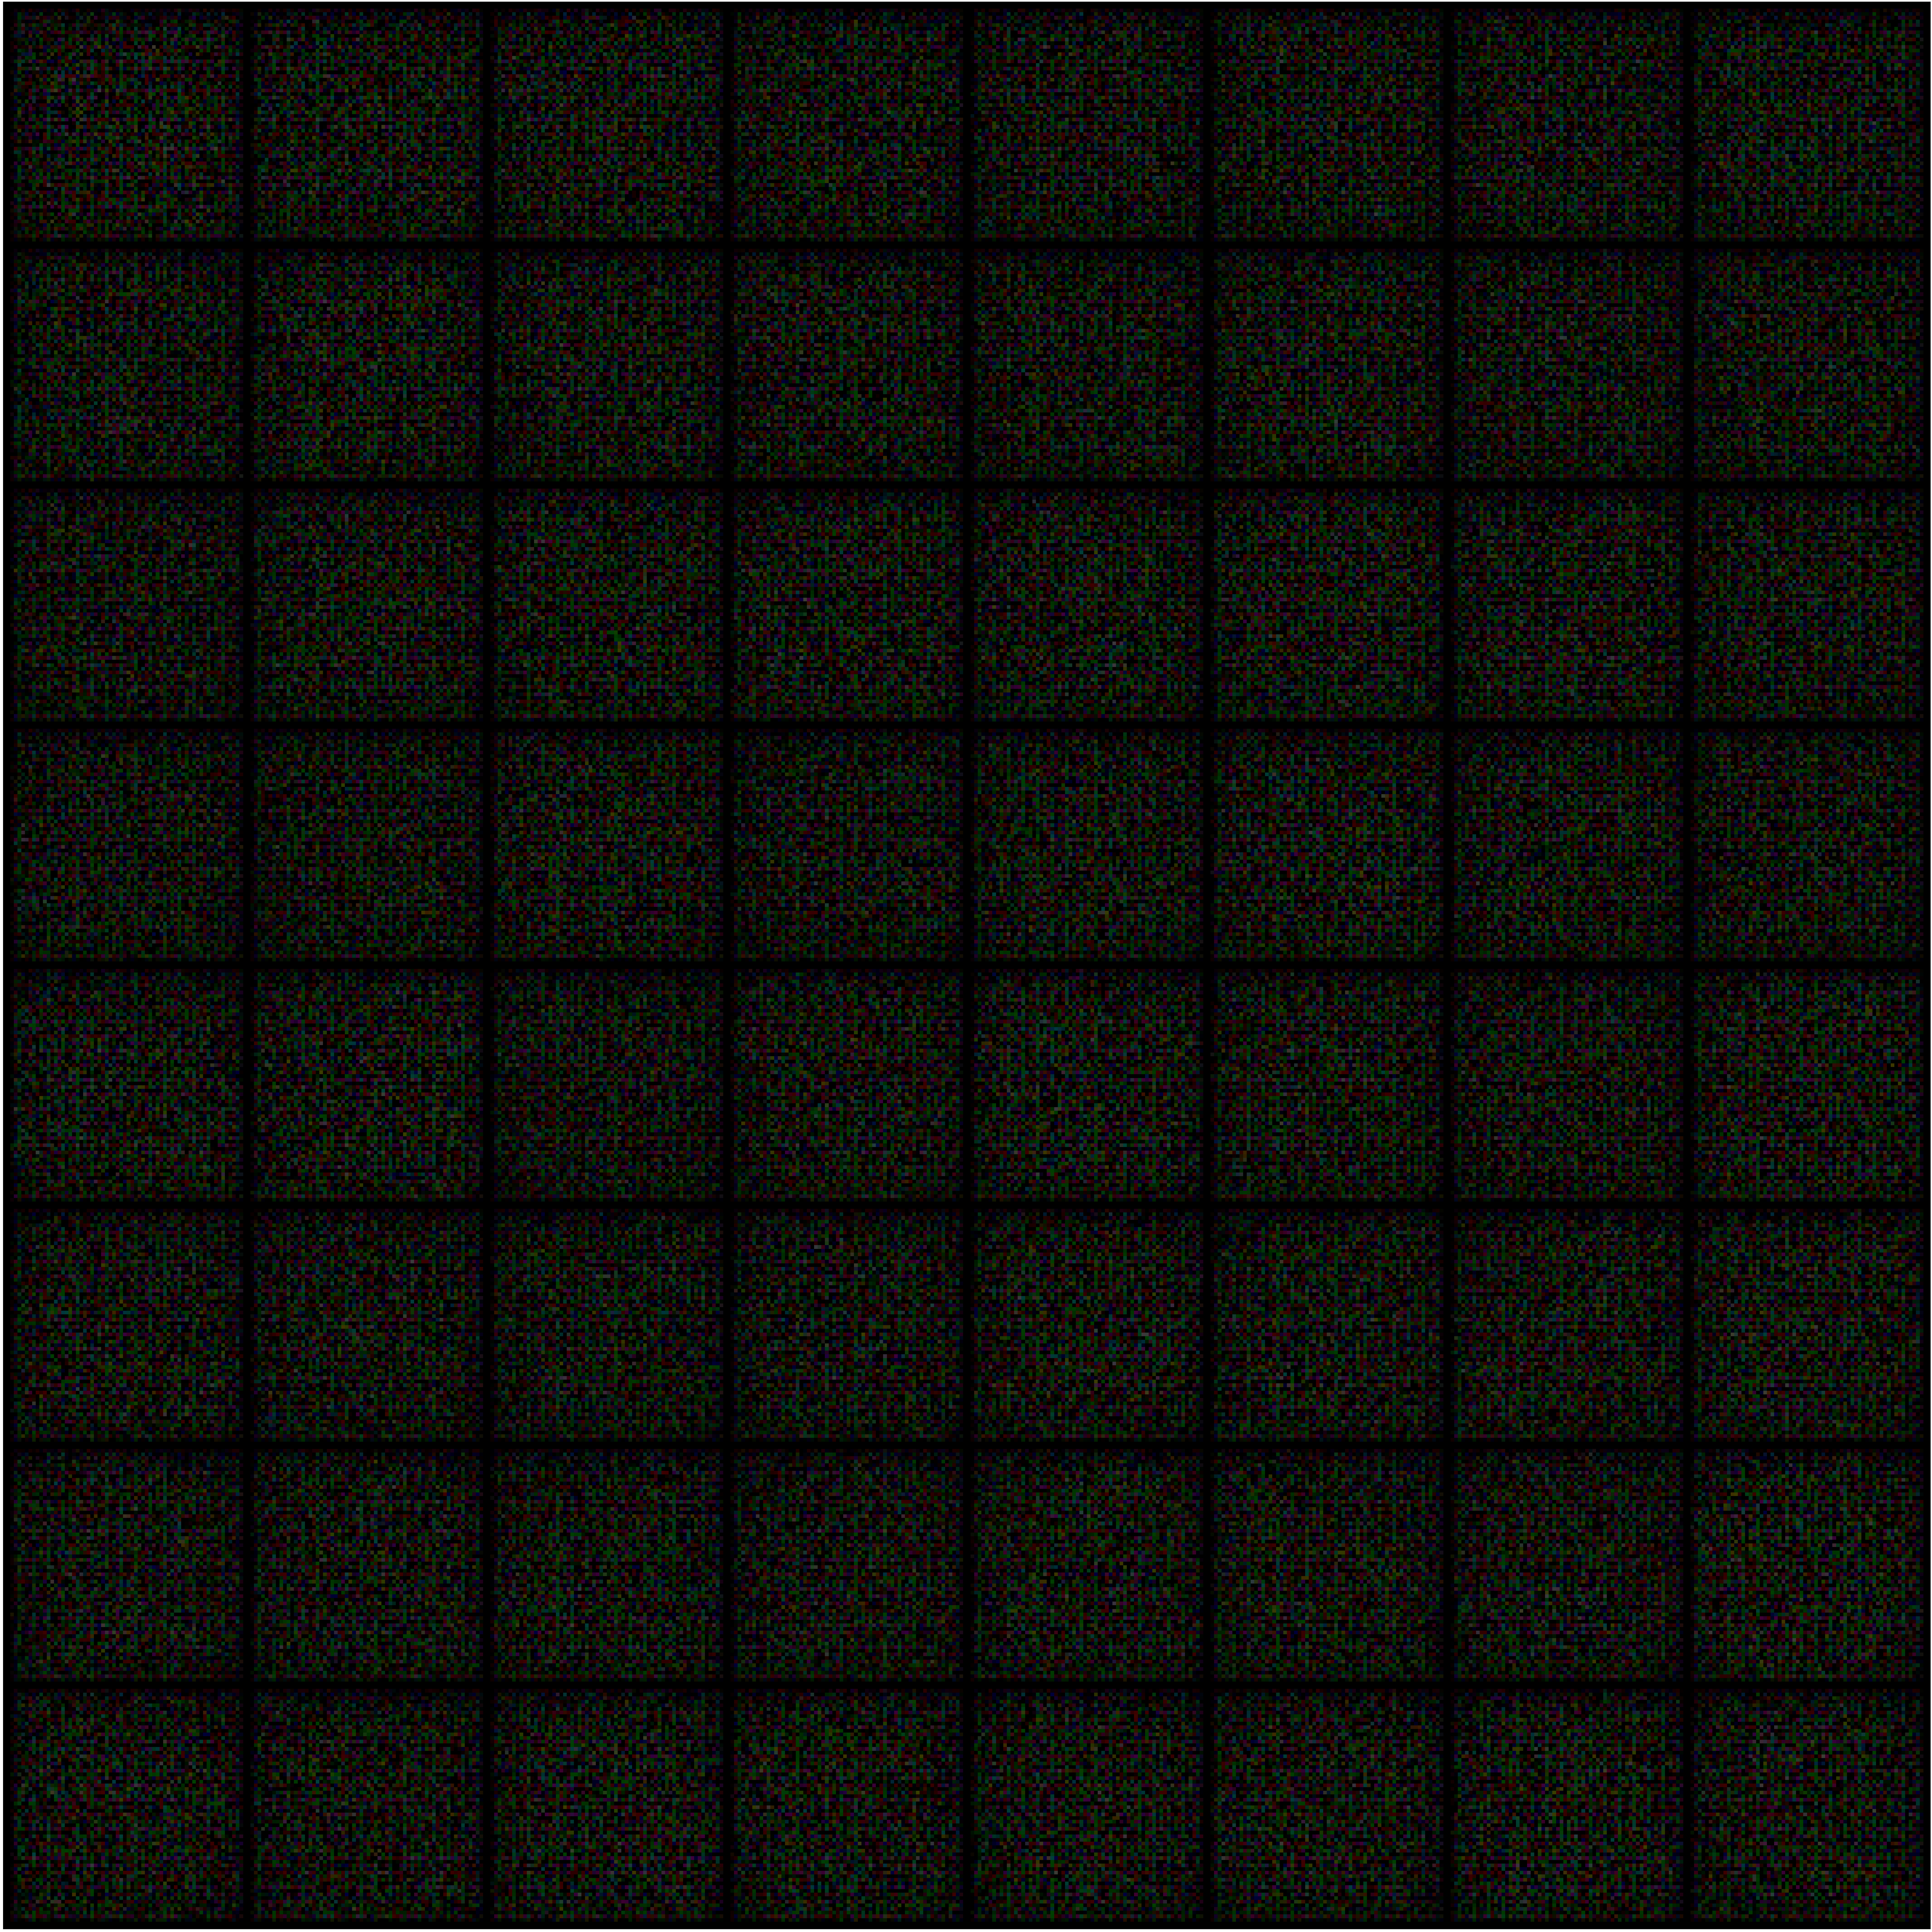

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


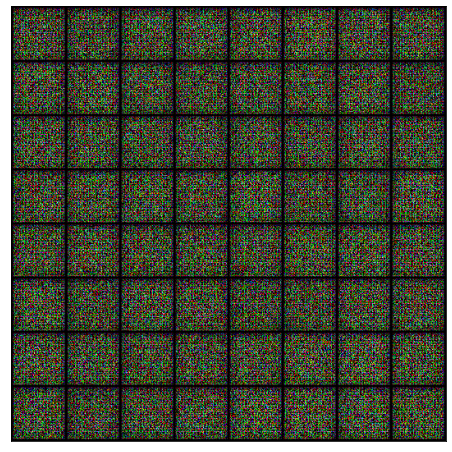

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/jayanthvikram2000/brain-tumour-synthetic-data-augmentation-gans


'https://jovian.ai/jayanthvikram2000/brain-tumour-synthetic-data-augmentation-gans'

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [ ]:
history = fit(epochs, lr)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/25], loss_g: 6.3653, loss_d: 0.2639, real_score: 0.9273, fake_score: 0.1639
Saving generated-images-0001.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 8.9155, loss_d: 0.1408, real_score: 0.9762, fake_score: 0.1081
Saving generated-images-0002.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 13.8641, loss_d: 0.0425, real_score: 0.9632, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 12.6587, loss_d: 0.0130, real_score: 0.9880, fake_score: 0.0000
Saving generated-images-0004.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 13.4500, loss_d: 0.0175, real_score: 0.9838, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 13.2193, loss_d: 0.0488, real_score: 0.9559, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 13.7094, loss_d: 0.0241, real_score: 0.9773, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 14.1526, loss_d: 0.5746, real_score: 0.9489, fake_score: 0.3844
Saving generated-images-0008.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 9.9122, loss_d: 0.0622, real_score: 0.9528, fake_score: 0.0014
Saving generated-images-0009.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 15.6442, loss_d: 0.2357, real_score: 0.8431, fake_score: 0.0000
Saving generated-images-0010.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.8811, loss_d: 0.0231, real_score: 0.9800, fake_score: 0.0025
Saving generated-images-0011.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 8.8658, loss_d: 0.0998, real_score: 0.9757, fake_score: 0.0712
Saving generated-images-0012.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 8.6153, loss_d: 0.0837, real_score: 0.9840, fake_score: 0.0647
Saving generated-images-0013.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 13.0699, loss_d: 0.1769, real_score: 0.9916, fake_score: 0.1522
Saving generated-images-0014.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 11.3257, loss_d: 0.0641, real_score: 0.9621, fake_score: 0.0001
Saving generated-images-0015.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.1863, loss_d: 0.0618, real_score: 0.9592, fake_score: 0.0115
Saving generated-images-0016.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 5.9000, loss_d: 0.1010, real_score: 0.9822, fake_score: 0.0784
Saving generated-images-0017.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.7206, loss_d: 0.0479, real_score: 0.9723, fake_score: 0.0188
Saving generated-images-0018.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 7.1784, loss_d: 0.0719, real_score: 0.9357, fake_score: 0.0028
Saving generated-images-0019.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.5834, loss_d: 0.0714, real_score: 0.9804, fake_score: 0.0498
Saving generated-images-0020.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 6.9252, loss_d: 0.0575, real_score: 0.9781, fake_score: 0.0343
Saving generated-images-0021.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 7.1372, loss_d: 0.0322, real_score: 0.9840, fake_score: 0.0157
Saving generated-images-0022.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 7.0086, loss_d: 0.0314, real_score: 0.9819, fake_score: 0.0128
Saving generated-images-0023.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 7.0048, loss_d: 0.0239, real_score: 0.9922, fake_score: 0.0159
Saving generated-images-0024.png


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 8.6879, loss_d: 0.0323, real_score: 0.9921, fake_score: 0.0240
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

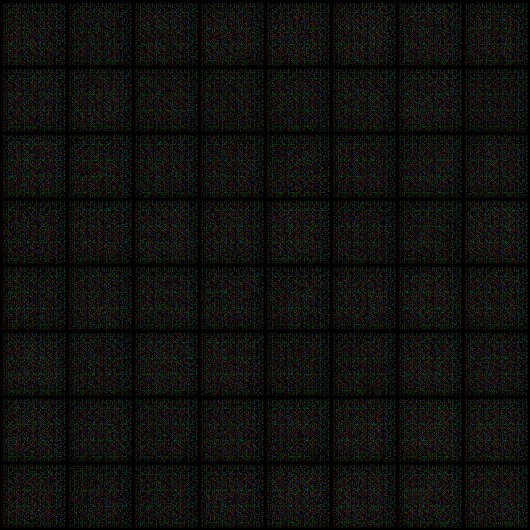

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

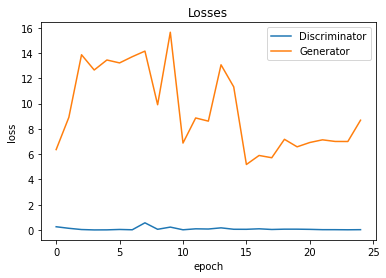

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

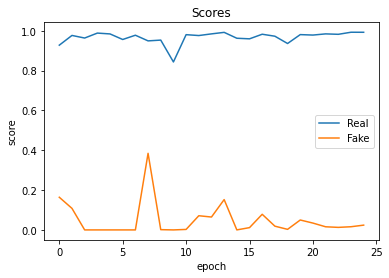

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/jayanthvikram2000/brain-tumour-synthetic-data-augmentation-gans


'https://jovian.ai/jayanthvikram2000/brain-tumour-synthetic-data-augmentation-gans'

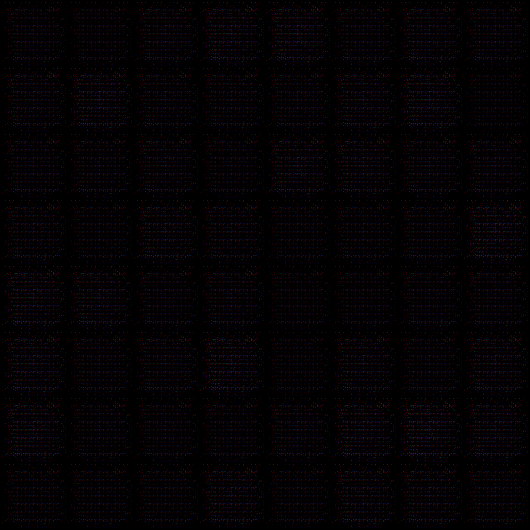

In [ ]:
Image('./generated/generated-images-0025.png')